In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar3=pd.read_csv('Solar 3.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar3['datetime']=pd.to_datetime(solar3['datetime'], format='%Y-%m-%d %H:%M:%S')
solar3= solar3.set_index('datetime')
solar3= solar3.asfreq('H')

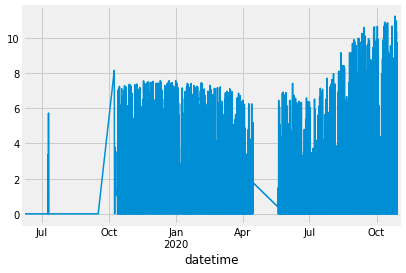

In [4]:
solar3['series_value'].plot()

In [17]:
#Split Train-Val for Solar3
# ==============================================================================
start_train='2019-10-10 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar3train=solar3.loc[start_train:end_train, :]
solar3val=solar3.loc[start_val:end_val, :]
solar3test=solar3.loc[start_test:, :]

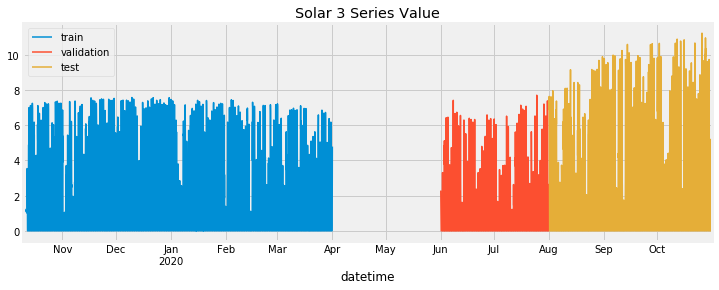

In [16]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar3train['series_value'].plot(ax=ax, label='train')
solar3val['series_value'].plot(ax=ax, label='validation')
solar3test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 3 Series Value')
ax.legend();

In [18]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:10:56 
Last fit date: None 
Skforecast version: 0.4.3 

In [19]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:09,  1.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:07,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:09,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:04,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:10,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:09,  1.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:13<00:02,  1.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:06,  1.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:03,  1.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:01,  1.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:00<00:00, 15.01s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.0301329090009135



In [20]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.030133,0.01,3.0,500.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.037639,0.10,3.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.037783,0.01,3.0,500.0
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.042905,0.10,3.0,100.0
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.098659,0.01,3.0,500.0
42,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.117917,0.10,3.0,100.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.120761,0.10,5.0,100.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.132371,0.01,5.0,500.0
44,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.144541,0.10,5.0,100.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.152804,0.10,3.0,100.0


In [21]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar3['series_value'],
    initial_train_size = len(solar3.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 2.491155302825033


In [22]:
# Predictions
# ==============================================================================
predictions

,pred
2020-08-01 01:00:00,3.836808
2020-08-01 02:00:00,4.830796
2020-08-01 03:00:00,4.673485
2020-08-01 04:00:00,4.058449
2020-08-01 05:00:00,2.350270
...,...
2020-10-31 19:00:00,0.095809
2020-10-31 20:00:00,0.514705
2020-10-31 21:00:00,1.510021
2020-10-31 22:00:00,2.673319


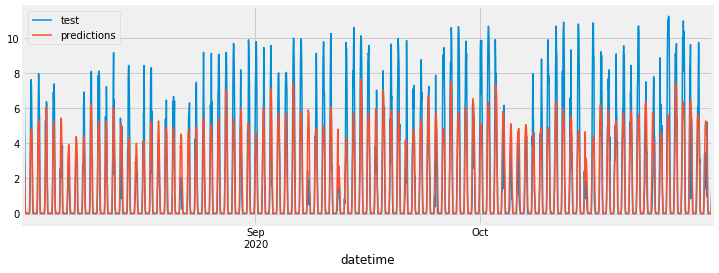

In [23]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar3test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [24]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [25]:
solar3test=solar3test.dropna()
solar3train=solar3train.dropna()

In [26]:
mean_absolute_scaled_error(solar3test.reset_index()['series_value'],predictions.reset_index()['pred'],solar3train.reset_index()['series_value'])

1.4164768335928706